**Import necessary Libraries**

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
warnings.filterwarnings("ignore")

In [47]:
# Load the dataset
df = pd.read_csv('yahoo_stock.csv')



In [48]:
df.shape

(1825, 7)

In [49]:
for column in df.columns:
    print(f'{column} : {df[column].dtype}')

Date : object
High : float64
Low : float64
Open : float64
Close : float64
Volume : float64
Adj Close : float64


In [50]:
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   adj_close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


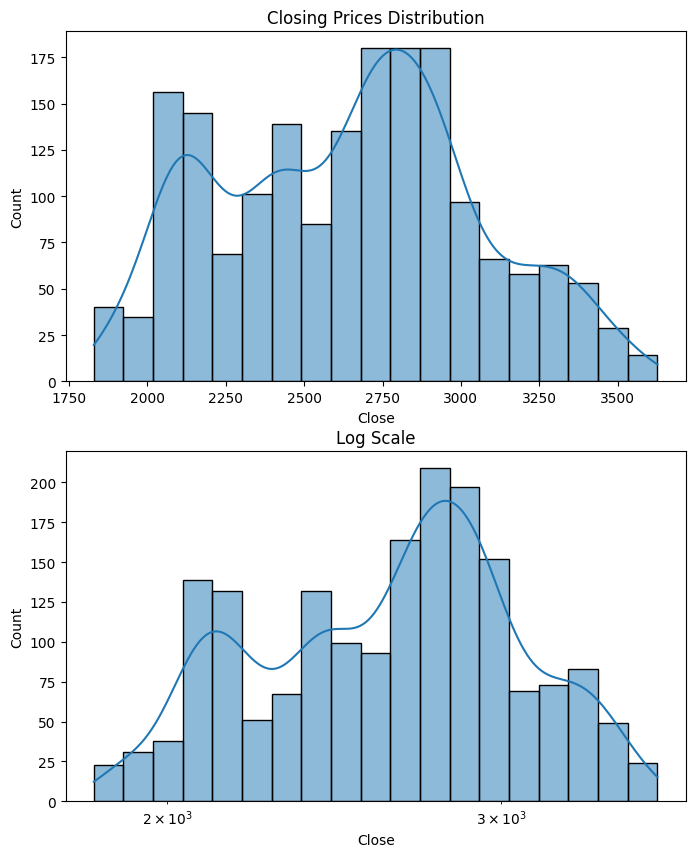

In [51]:
fig, axs = plt.subplots(2, figsize=(8,10))
sns.histplot(data=df, x='Close', ax=axs[0], kde=True)
axs[0].set_title('Closing Prices Distribution')
sns.histplot(data=df, x='Close', ax=axs[1], log_scale=True, kde=True)
axs[1].set_title('Log Scale')
plt.show()

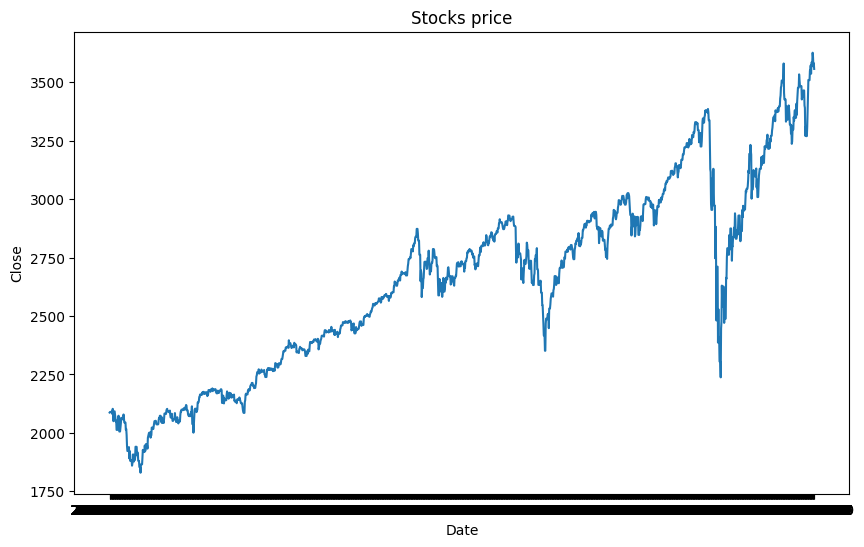

In [52]:
## making the lineplot - PLOT OF CLOSE VALUES AND DATE
# df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=df)
plt.title("Stocks price")
plt.show()

<Figure size 800x600 with 0 Axes>

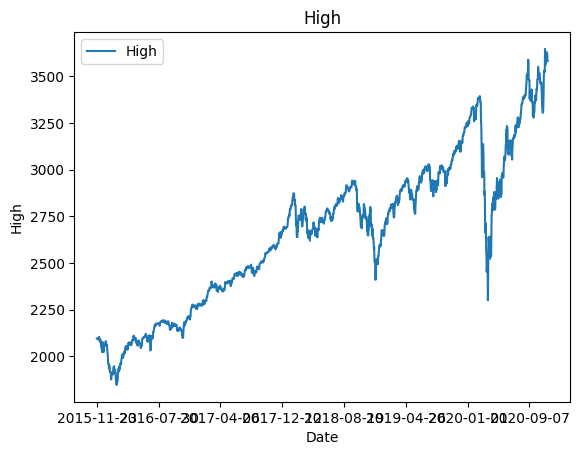

<Figure size 800x600 with 0 Axes>

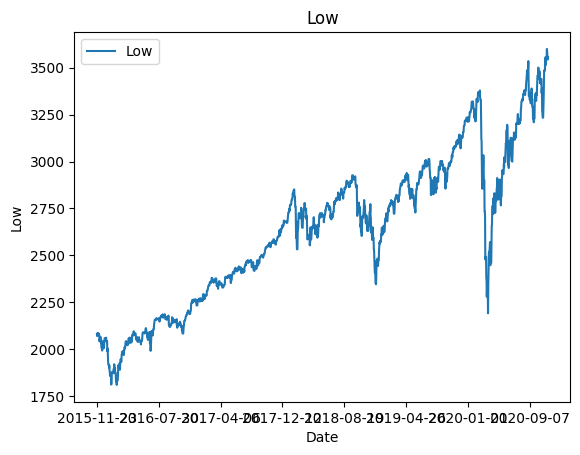

<Figure size 800x600 with 0 Axes>

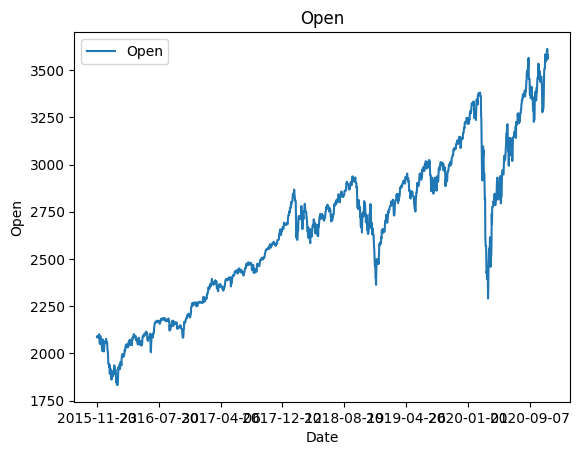

<Figure size 800x600 with 0 Axes>

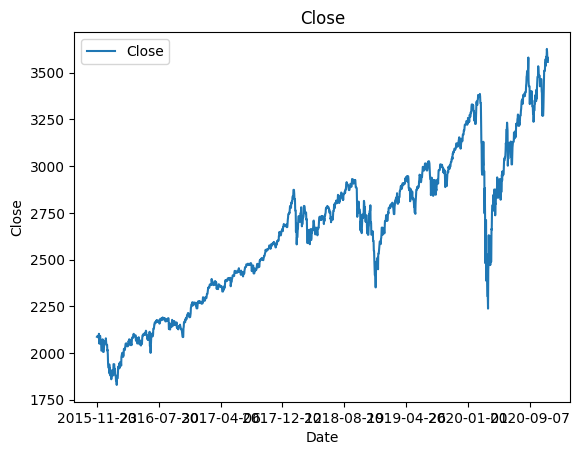

<Figure size 800x600 with 0 Axes>

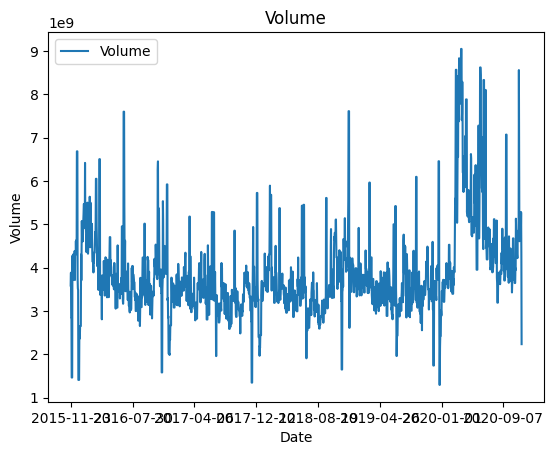

<Figure size 800x600 with 0 Axes>

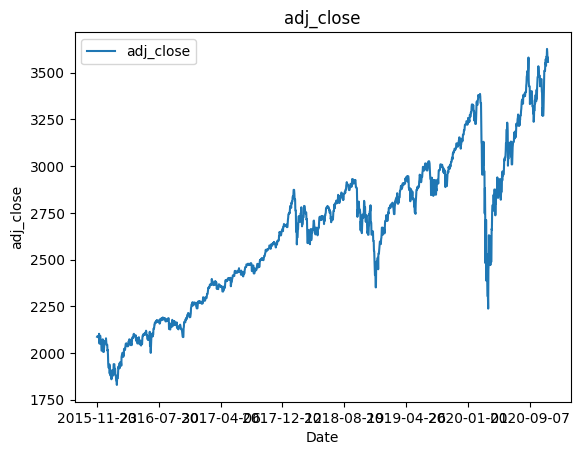

In [53]:
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(8, 6))
        df.plot(x='Date', y=column)
        plt.title(column)
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.show()

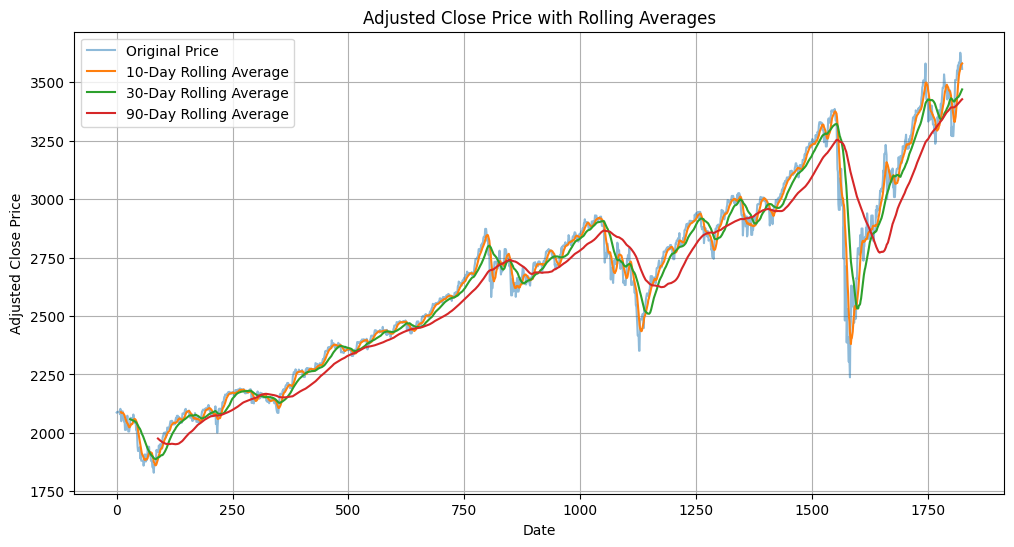

In [54]:
# Calculate rolling averages with different windows
rolling_10d = df['adj_close'].rolling(window=10).mean()
rolling_30d = df['adj_close'].rolling(window=30).mean()
rolling_90d = df['adj_close'].rolling(window=90).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df['adj_close'], label='Original Price', alpha=0.5)
plt.plot(rolling_10d, label='10-Day Rolling Average')
plt.plot(rolling_30d, label='30-Day Rolling Average')
plt.plot(rolling_90d, label='90-Day Rolling Average')
plt.title('Adjusted Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


**Data Preprocessing**

In [55]:
# Convert Date to datetime type for time-series analysis
df['Date'] = pd.to_datetime(df['Date'])

In [56]:
# Remove non-trading day duplicates
# (where values are repeated from previous row)
cols_to_check = ['Open', 'High', 'Low', 'Close', 'adj_close', 'Volume','Date']
mask = (df[cols_to_check].shift(1) == df[cols_to_check]).all(axis=1)
df = df[~mask].copy().reset_index(drop=True)

In [57]:
# Set Date as the index for time-series analysis
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
# Drop any rows with missing values (if any)
df.dropna(inplace=True)

**Base Line Models**

In [58]:
# Baseline model (using only raw 'Close' price)
X_baseline = df[['Close']].values

# Scale data
scaler_baseline = MinMaxScaler()
X_scaled_baseline = scaler_baseline.fit_transform(X_baseline)

# Prepare sequences for LSTM
def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X_seq_baseline, y_seq_baseline = create_sequences(X_scaled_baseline)

# Train-test split (maintain temporal order)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_seq_baseline, y_seq_baseline, test_size=0.2, shuffle=False)

# Flatten for non-LSTM models
X_train_base_flat = X_train_base.reshape(X_train_base.shape[0], -1)
X_test_base_flat = X_test_base.reshape(X_test_base.shape[0], -1)

In [59]:
# LSTM Baseline
lstm_base = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_base.shape[1], 1)),
    Dense(1)
])
lstm_base.compile(optimizer='adam', loss='mse')
lstm_base.fit(X_train_base, y_train_base, epochs=10, verbose=0)

# Random Forest Baseline
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X_train_base_flat, y_train_base)

# SVM Baseline
svm_base = SVR(kernel='rbf', C=10)  # Using best params from your original code
svm_base.fit(X_train_base_flat, y_train_base)

SVR(C=10)

In [60]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, is_lstm=False, scaler=None):
    if is_lstm:
        pred = model.predict(X_test)
    else:
        pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    if scaler:
        # Inverse scaling for RMSE in original units
        pred = scaler.inverse_transform(pred.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    return rmse


def r2_value(model, X_test, y_test, is_lstm=False, scaler=None):
    if is_lstm:
        pred = model.predict(X_test)
    else:
        pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    if scaler:
        # Inverse scaling for RMSE in original units
        pred = scaler.inverse_transform(pred.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    return r2

# Evaluate baseline models
results_base = {
    'LSTM': evaluate_model(lstm_base, X_test_base, y_test_base, True, scaler_baseline),
    'RandomForest': evaluate_model(rf_base, X_test_base_flat, y_test_base, False, scaler_baseline),
    'SVM': evaluate_model(svm_base, X_test_base_flat, y_test_base, False, scaler_baseline)
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


**Feature Engineering**

In [61]:
# Feature Engineering
## Lag Features: Add previous days' prices as features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)
df['lag_5'] = df['Close'].shift(5)
df['lag_10'] = df['Close'].shift(10)

In [62]:
## Rolling Statistics: Add rolling mean and standard deviation
df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
df['rolling_std_5'] = df['Close'].rolling(window=5).std()
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_std_10'] = df['Close'].rolling(window=10).std()

In [63]:
## Time Features: Extract features from date
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday

In [64]:
# Drop missing values generated from lag and rolling features
df = df.dropna()
# data=df
# Preparing the data for modeling
data = df[['Close', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'rolling_mean_5', 'rolling_std_5', 'rolling_mean_10', 'rolling_std_10', 'month', 'day', 'weekday']]


In [65]:
# Scaling the data
# data=df
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [66]:
# Prepare inputs and labels
def make_data(scaled_data, time_step=50):
    inputs = []
    labels = []

    for i in range(len(scaled_data) - time_step):
        inputs.append(scaled_data[i:i + time_step])
        labels.append(scaled_data[i + time_step, 0])  # Predicting the 'Close' price

    return np.array(inputs), np.array(labels)

In [67]:
# Creating training and testing data
X, y = make_data(scaled_data)
print(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape

[[0.1226702  0.13929574 0.15215562 ... 1.         0.06666667 0.5       ]
 [0.14607054 0.1226702  0.13929574 ... 1.         0.1        0.66666667]
 [0.14607054 0.14607054 0.1226702  ... 1.         0.13333333 0.83333333]
 ...
 [0.96711598 0.99033286 1.         ... 0.90909091 0.56666667 0.33333333]
 [0.97494769 0.96711598 0.99033286 ... 0.90909091 0.6        0.5       ]
 [0.96141466 0.97494769 0.96711598 ... 0.90909091 0.63333333 0.66666667]]


(1412, 50, 13)

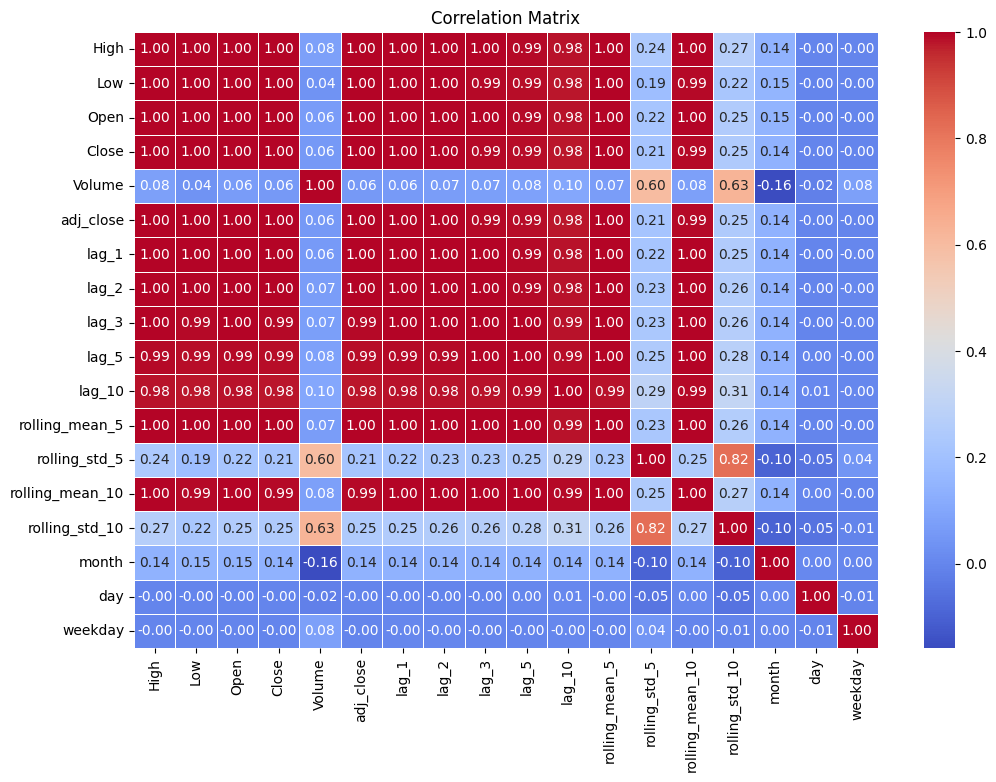

In [68]:
# --- Feature Selection: Correlation-based Feature Selection ---
# Calculate Correlation Matrix
correlation_matrix = df.corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Select features with high correlation to 'Close' (threshold > 0.5)
correlation_threshold = 0.5
correlated_features = correlation_matrix['Close'].abs()[correlation_matrix['Close'].abs() > correlation_threshold].index
scaler1 = MinMaxScaler()
# Filter the features based on correlation
df_filtered = df[correlated_features]
scaled_data_filtered = scaler1.fit_transform(df_filtered)
X_filtered, y_filtered=make_data(scaled_data_filtered)

x_filtered=df[correlated_features].drop(columns=['Close'])

y_filtered=df[correlated_features]['Close']


In [69]:
from sklearn.decomposition import PCA
# --- Dimensionality Reduction: PCA ---
# PCA: Principal Component Analysis (now used for dimensionality reduction)
pca = PCA(n_components=4)  # Reduce to 4 components
X_pca = pca.fit_transform(x_filtered)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_train, X_test, y_train, y_test

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0945 - val_loss: 0.0133
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0080
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7951e-04 - val_loss: 0.0052
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6345e-04 - val_loss: 0.0035
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4809e-04 - val_loss: 0.0035
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9316e-04 - val_loss: 0.0020
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8454e-04 - val_loss: 0.0029
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5917e-04 - val_loss: 0.0021
Epoch 9/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1646e-04 - val_loss: 0.0019
Epoch 10/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4762e-04 - val_loss: 0.0016
Epoch 11/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0517e-04 - val_loss: 0.0016
Epoch 12/150
45/

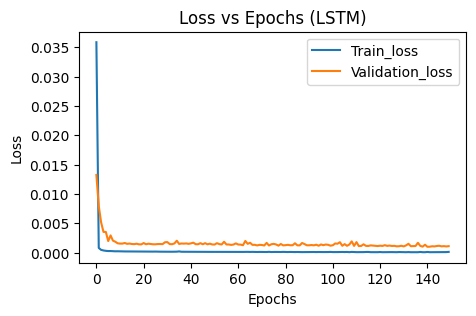

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R²: 0.952730420010321


In [70]:
# --- LSTM Model ---
# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation="relu", input_shape=(X_train_pca.shape[1], X_train_pca.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Model summary
lstm_model.summary()

# Training the LSTM model
history = lstm_model.fit(X_train_pca, y_train_pca, epochs=150, validation_data=(X_test_pca, y_test_pca))

# Plotting training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss vs Epochs (LSTM)")
plt.show()

# Making predictions with LSTM
lstm_predictions = lstm_model.predict(X_test_pca)

# Inverse scaling to get actual predictions
y_pred_lstm = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], X_test_pca.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test_pca.reshape(-1, 1), np.zeros((y_test_pca.shape[0], X_test_pca.shape[2] - 1))), axis=1))[:, 0]

# Evaluate LSTM model
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)
print(f"R²: {r2_lstm}")

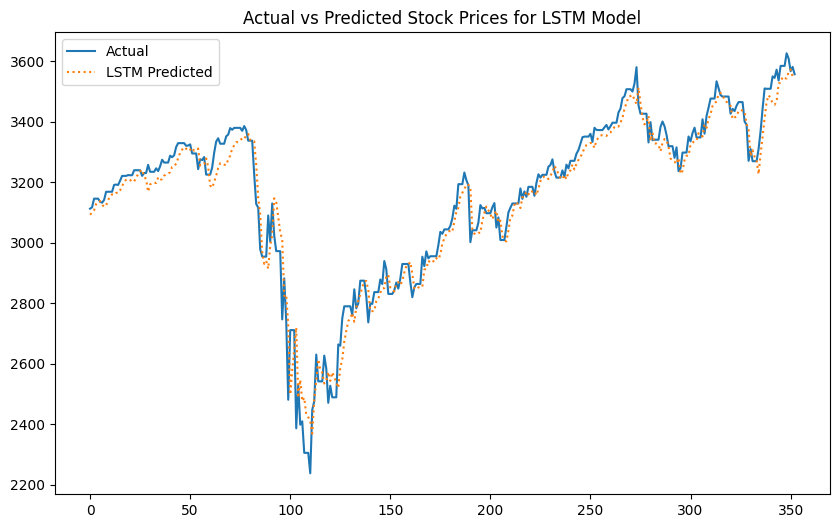

In [71]:
# Plot actual vs predicted values for all models
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Predicted', linestyle=':')
plt.legend()
plt.title("Actual vs Predicted Stock Prices for LSTM Model")
plt.show()

In [72]:
# --- SVM Model with with PCA GridSearchCV ---
# Flatten the data to 2D for Random Forest and SVM
X_train_svm_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1] * X_train_pca.shape[2]))
X_test_svm_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1] * X_test_pca.shape[2]))
# Hyperparameter tuning for SVM using GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
}

svm_model = SVR()
svm_grid_search = GridSearchCV(svm_model, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
svm_grid_search.fit(X_train_svm_pca, y_train)

# Best parameters from Grid Search
print(f"Best parameters for SVM: {svm_grid_search.best_params_}")

# Predict using SVM
svm_predictions = svm_grid_search.predict(X_test_svm_pca)

# Evaluate SVM
mse_svm = mean_squared_error(y_test, svm_predictions)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, svm_predictions)

print(f"SVM - RMSE: {rmse_svm}, R²: {r2_svm}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SVM: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
SVM - RMSE: 0.030174810779122943, R²: 0.9616365254909495


In [74]:
# --- Random Forest Model with GridSearchCV ---
X_train_rf_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1] * X_train_pca.shape[2]))
X_test_rf_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1] * X_test_pca.shape[2]))

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf_pca, y_train)

# Predict using Random Forest
rf_predictions = rf_model.predict(X_test_rf_pca)


# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, rf_predictions)
# Print model evaluation results

print(f"Random Forest - RMSE: {rmse_rf}, R²: {r2_svm}")

Random Forest - RMSE: 0.11576147539957027, R²: 0.9616365254909495


In [75]:
# Using your existing feature-engineered evaluation code
results_fe = {
    'LSTM': (rmse_lstm),
    'RandomForest': (rmse_rf),
    'SVM': (rmse_svm)
}

In [76]:
# Prepare comparison data
models = ['RandomForest', 'SVM']
rmse_base = [results_base[m] for m in models]
rmse_fe = [results_fe[m] for m in models]



In [77]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models * 2,
    'Feature Engineering': ['Before']*2 + ['After']*2,
    'RMSE': rmse_base + rmse_fe
})

print(comparison_df.pivot(index='Model', columns='Feature Engineering', values=['RMSE']))

                         RMSE            
Feature Engineering     After      Before
Model                                    
RandomForest         0.115761  183.848267
SVM                  0.030175  492.691690


In [79]:
print("Before FE R2 Score: LSTM", r2_value(lstm_base, X_test_base, y_test_base, True, scaler_baseline))
print("After FE R2 Score: LSTM", r2_lstm)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Before FE R2 Score: LSTM 0.878528287209938
After FE R2 Score: LSTM 0.952730420010321
